# Сборный проект

### Введение

**Исходные данные:**

Исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) до 2016 г. 

**Цель работы:**

Выявить определяющие успешность игры закономерности.
Планирование кампании на 2017 г. 

**План исследования:**
1. Выполнить предобработку данных.
2. Провести исследовательский анализ данных, в т.ч. выявить и устранить аномалии в данных. 
3. Составить портрет пользователя каждого региона. 
4. Проверить гипотезы о платформах и жанрах игр.   

### Загрузка данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
# Открываем файл с данными 
games = pd.read_csv('datasets/games.csv')

In [3]:
# Выведем на экран 10 строк из набора данных
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
# Выведем основную информацию о датафрейме 
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:**

Для анализа предоставлен датафрейм, состоящий из 16715 строк. 

Датафрейм содержит следующую информацию:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию

В столбцах `Name`, `Year_of_Release`, `Critic_Score`, `User_Score`, `Rating` есть пропущенные значения.

Названия столбцов не соответствует "правилам хорошего тона". 

### Предобработка данных

#### Переименование столбцов

In [5]:
# переименуем столбцы
games = games.rename(columns={'Name':'name', 
                              'Platform':'platform', 
                              'Year_of_Release':'year_of_release', 
                              'Genre':'genre', 
                              'NA_sales':'na_sales',
                              'EU_sales':'eu_sales',
                              'JP_sales':'jp_sales',
                              'Other_sales':'other_sales',
                              'Critic_Score':'critic_score',
                              'User_Score':'user_score',
                              'Rating':'rating',})

# проверим, что переименование прошло успешно
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Вывод:**

Изначальные названия столбцов не соответствовали типу snake case. 

Выполнили корректировку названий столбцов.

#### Обработка пропусков

In [6]:
# делаем копию текущего датасета
tmp = games.copy()

missing = (pd.DataFrame({'Количество пропусков': tmp.isnull().sum(), 'Доля пропусков, %': tmp.isnull().mean().round(4)*100})
           .style.background_gradient(cmap='YlOrRd', low=0.5, high=0.3))
missing

,Количество пропусков,"Доля пропусков, %"
name,2,0.010000
platform,0,0.000000
year_of_release,269,1.610000
genre,2,0.010000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8578,51.320000
user_score,6701,40.090000


**Название игр и жанр**

In [7]:
# проверим что находится в строках, в которых пропущены имя или жанр
games[games['name'].isna() | games['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# удалим эти строки из датафрейма
games = games.dropna(subset=['name']).reset_index(drop=True)

Выявили в выборке 2 "безымянные" игры 1993 года, вероятно, на платформе Sega Genesis, которые утратили популярность к 2016 г. Удалим эти строки из датафрейма.

Отсутствие значений может быть связано как с техническими проблемами при выгрузке данных (если данные об этих играх хранились в базах данных с их выпуска), так и с человеческим фактором (возможно эти данные не были заполнены изначально).

**Год выпуска**

In [9]:
# т.к. пропуски в столбце year_of_release занимают всего 1,6%, удалим строки с пропусками
games = games.dropna(subset=['year_of_release']).reset_index(drop=True)

# проверим, что пропусков в столбце year_of_release больше нет
games.isna().mean().sort_values(ascending=False)*100

critic_score       51.453418
rating             40.598395
user_score         40.166626
year_of_release     0.000000
platform            0.000000
name                0.000000
genre               0.000000
jp_sales            0.000000
eu_sales            0.000000
na_sales            0.000000
other_sales         0.000000
dtype: float64

Выявили пропуски в 269 строках (что составляет всего 1,6%). Удалили эти строки из выборки.

Можно предположить, что пропуски связаны с некорректной выгрузкой данных из базы данных. 

**Оценка пользователей**

In [10]:
# проверим что находится в строках, в которых пропущены оценки пользователей
games[games['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16440,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16441,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [11]:
# проверим какие вообще значения есть в столбце
games['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [12]:
# проверим сколько занимают в процентном соотношении строки со значением TBD
round((len(games[games['user_score'] == 'tbd'])/len(games))*100, 2)

14.45

In [13]:
# заменим значения tbd на пропуски
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

Выявили, что в основном в столбце размещены числовые значения. 

Но кроме числовых значений есть значение "tbd", что в переводе с англ.языка означает "to be determined", т.е. "будет определено".

Вероятно, рано или поздно эти данные появятся, но пока их нет, заменим ~~на медианные~~ на пропуски. 

Пропущенные значения оставим как есть. Пользователи могли не выставлять оценки играм. 

**Рейтинг**

In [14]:
# проверим какие значения размещаются в столбце рейтинга
games['rating'].value_counts()

rating
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: count, dtype: int64

In [15]:
# проверим какой процент пропущенных значений в каждом регионе
(games[games['rating'].isna()][['na_sales', 'eu_sales', 'jp_sales']].sum()/games[['na_sales', 'eu_sales', 'jp_sales']].sum())*100

na_sales    28.235923
eu_sales    25.405471
jp_sales    64.831401
dtype: float64

In [16]:
# заменим пропущенные значения на NA
games['rating'] = games['rating'].fillna('NA')

То, что для некоторых игр, значения рейтинга отсутствуют, кажется нормальным. Рейтинг мог не рассчитываться для некоторых игр из выборки, **например, из-за региона. Игры могли получать региональный возрастной рейтинг, а не северо-американский ESRB.**

Учитывая большой процент строк без рейтинга, заменим их значением "NA". 

**Оценка критиков**

In [17]:
# проверим какие вообще значения есть в столбце
games['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

То, что для некоторых игр, значения оценки критиков отсутствуют, кажется нормальным. Критики могли не оценивать все игры из выборки.

Учитывая большой процент строк без оценок, оставим пропущенные значения на своих местах.

In [18]:
# проверим результаты обработки пропусков
tmp = games.copy()

missing = (pd.DataFrame({'Количество пропусков': tmp.isnull().sum(), 'Доля пропусков, %': tmp.isnull().mean().round(4)*100})
           .style.background_gradient(cmap='YlOrRd', low=0.5, high=0.3))
missing

,Количество пропусков,"Доля пропусков, %"
name,0,0.000000
platform,0,0.000000
year_of_release,0,0.000000
genre,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8461,51.450000
user_score,8981,54.620000


**Вывод:**
1. Выявили в выборке 2 "безымянные" игры 1993 года, которые утратили популярность к 2006 г. и удалили эти строки.
2. В строках, где был пропущен год выпуска, заменили значения исходя из названий игры, а для остальных (которых большинство) пустые значения заменили на медиану. 
3. В столбце с оценками пользователей заменили значения "tbd" на медиану, оставив пропуски без обработки. 
4. В столбцах с рейтингом и оценкой критиков оставили пропуски без обработки.

Отсутствие данных может быть связано с низкими продажами игр, в следствии чего не набралось необходимого количества индивидуальных отзывов для получения итоговой оценки.

#### Поиск дубликатов

In [19]:
# проверим количество явных дубликатов в данных
games.duplicated().sum()

np.int64(0)

In [20]:
# проверим неявные дубликаты
games[['name', 'platform', 'year_of_release']].duplicated().sum()

np.int64(1)

In [21]:
# проверим данные в строке с неявными дубликатами
games.loc[games[['name', 'platform', 'year_of_release']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15969,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [22]:
# проверим список дубликатов
games[games['name']=='Madden NFL 13'].sort_values(by='platform')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
600,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
15969,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E
5800,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
3933,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
6956,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
503,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E


In [23]:
# удалим лишнюю строку по индексу
games = games.drop(index=[15969])

#### Преобразование типов данных

In [24]:
# данные в столбце year_of_release приведем к целочисленному типу (т.к. год не может быть нецелым числом)
games['year_of_release'] = games['year_of_release'].astype('int64')

In [25]:
# данные в столбце user_score приведем к типу float
games['user_score'] = pd.to_numeric(games['user_score'])

**Вывод:**

В датафрейме выявили столбцы, в которых были применены не оптимальные типы данных:
- данные в столбце `year_of_release` привели к целочисленному типу;
- данные в столбце `user_score` привели к вещественному типу

In [26]:
# выведем информацию о получившемся датафрейме
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


#### Подготовка данных

In [27]:
# добавим столбец, в котором посчитаем суммарные продажи во всех регионах
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

# проверим, что столбец добавился
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NA,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NA,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NA,28.31


### Исследовательский анализ данных

#### Статистика выпуска игр за разные годы

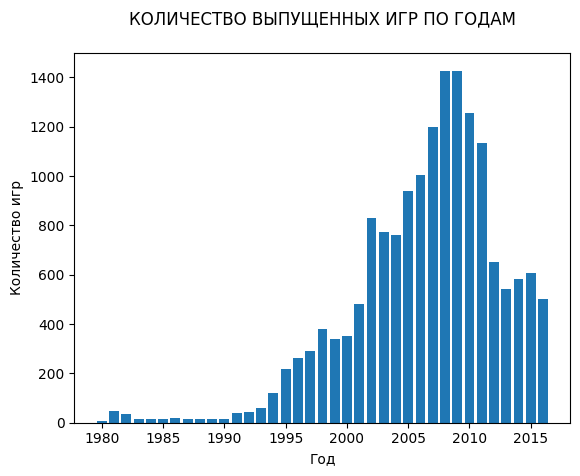

In [28]:
# посмотрим на столбчатую диаграмму плотности распределения игр в зависимости от года
games_counts = games['year_of_release'].value_counts().reset_index(drop=False)
plt.bar(x=games_counts['year_of_release'], height=games_counts['count'])
plt.title('Количество выпущенных игр по годам\n'.upper())
plt.xlabel('Год')
plt.ylabel('Количество игр');

In [29]:
games['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

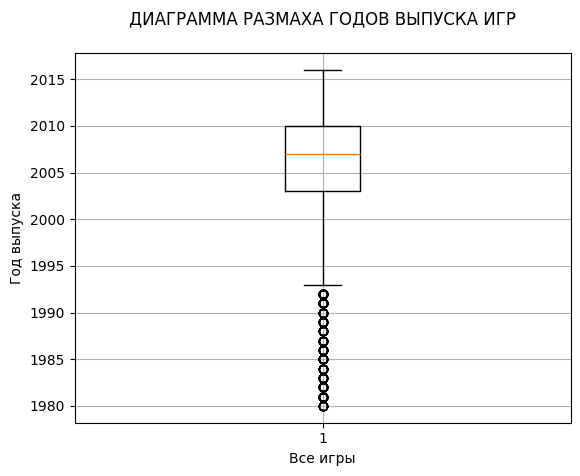

In [30]:
# построим диаграмму разамаха для столбца year_of_release
plt.boxplot(games['year_of_release'])
plt.title('Диаграмма размаха годов выпуска игр\n'.upper())
plt.grid()
plt.xlabel('Все игры')
plt.ylabel('Год выпуска');

In [31]:
# удалим строки с играми, год выпуска которых ранее 1993 года
games_actual = games[games['year_of_release'] > 1993]

# проверим, что получили корректный датафрейм
games_actual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16078 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16078 non-null  object 
 1   platform         16078 non-null  object 
 2   year_of_release  16078 non-null  int64  
 3   genre            16078 non-null  object 
 4   na_sales         16078 non-null  float64
 5   eu_sales         16078 non-null  float64
 6   jp_sales         16078 non-null  float64
 7   other_sales      16078 non-null  float64
 8   critic_score     7979 non-null   float64
 9   user_score       7459 non-null   float64
 10  rating           16078 non-null  object 
 11  sum_sales        16078 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


**Вывод:**

Больше всего игр было выпущено в 2007 году. 

До 1992 года игры выпускались довольно редко. Статистика за период, который был на 20 лет раньше, будет мало полезна. 

Удалили из датафрейма строки с играми, год выпуска которых ранее 1992 года. 

#### Статистика продаж на различных платформах

In [32]:
# получим топ-5 платформ, которые за все время продали больше всех игр
top5_platforms = games_actual.pivot_table(index=['platform'], values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False).head(5)

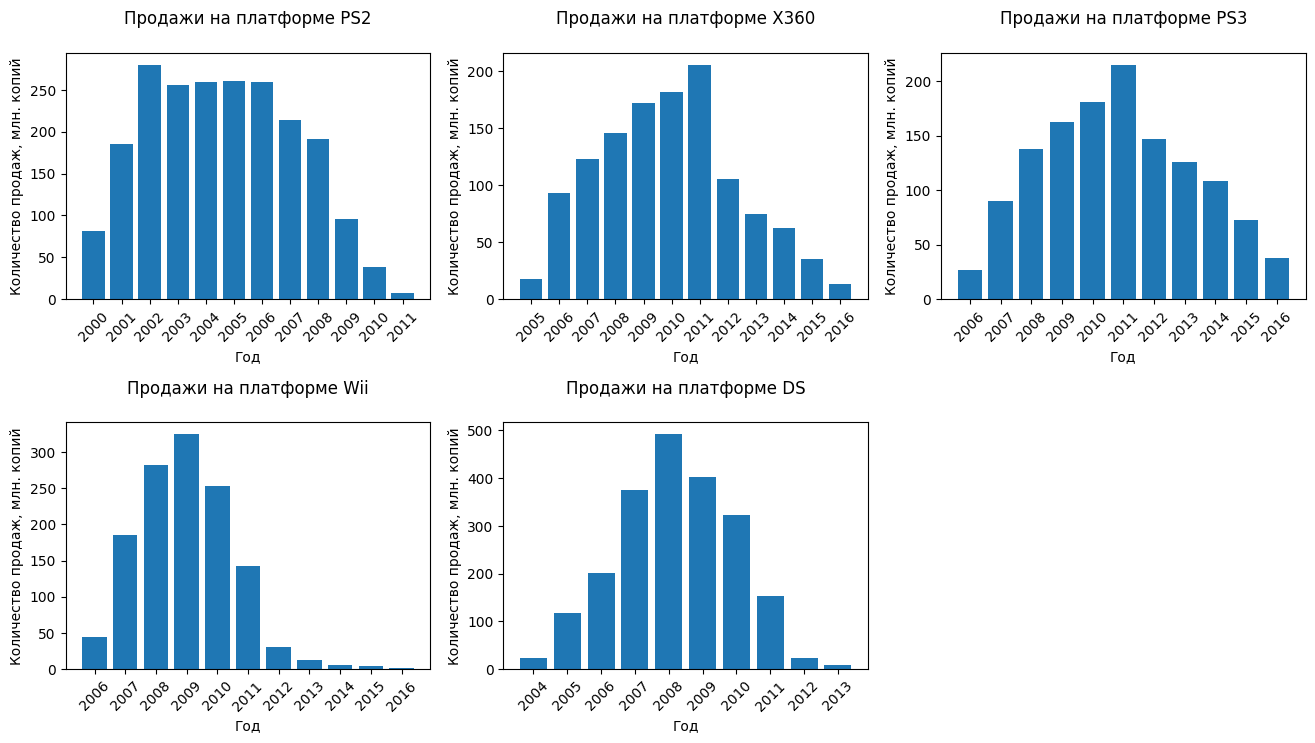

In [33]:
# построим графики распределения продаж по годам  для каждой из топ-5 платформ 

i = 1
fig = plt.figure(figsize=(16,8))

for platform in top5_platforms.index:
    plt.subplot(2, 3, i)
   
    # сделаем выборку данных по платформе
    sales_counts_by_year = games_actual[games_actual['platform']==platform]['year_of_release'].value_counts().reset_index(drop=False)

    # построим график
    plt.bar(x = sales_counts_by_year['year_of_release'], height=sales_counts_by_year['count'])
    plt.title(f'Продажи на платформе {platform}\n')
    plt.xlabel('Год')
    plt.ylabel('Количество продаж, млн. копий')
    plt.xticks(sales_counts_by_year['year_of_release'], rotation=45)
    i+=1

plt.subplots_adjust(hspace = 0.5)

In [34]:
# определим срок жизни платформ точнее
temp = games.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 
time_life['life'].median()

np.float64(7.0)

**Вывод:**

На графиках можно отследить, что:
- популярность платформ обычно нарастает постепенно и достигает своего пика за 3-4 года;
- спад актуальности платформы происходит также постепенно за 4-5 лет. 

Исходя из расчетов выявили, что медианный срок жизни платформы составляет 7 лет. Будем иметь его в виду при выборе актуального периода для нашего исследования. 

Но есть исключения - платформа PS2 и X360: 
- платформа PS2 достигла пика популярности всего за 2 года и далее удерживала популярность на протяжении почти 7 лет. Можно отследить, что спад ее популярности пришелся на выпуск новой версии платформы PS3;
- платформа X360 набирала свою популярность в течение целых 6 лет. 

#### Выбор потенциально прибыльных платформ

В результате анализа популярности платформ можно сделать вывод, что для целей настоящей работы не имеет смысла рассматривать данные старше 5 лет. 

Используя срез данных с 2013 года мы сможем отследить те платформы, которые становятся популярными в последнее время, и те платформы, чья популярность идет на спад. 

К тому же индустрия игр развивается довольно стремительно, поэтому слишком ранние данные могут исказить выводы. 

In [35]:
# сохраним срез данных в новый датафрейм
games_for_analysis = games[(games['year_of_release'] > 2012)]

# проверим, что получили корректный датафрейм
games_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2233 entries, 16 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       1192 non-null   float64
 10  rating           2233 non-null   object 
 11  sum_sales        2233 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


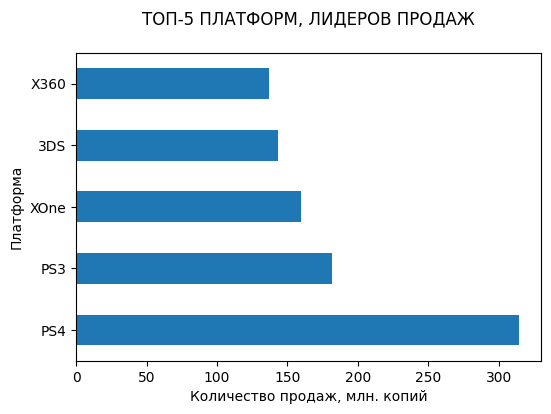

In [36]:
# найдем топ-5 платформ, которые лидируют по продажам, и построим график
top5_platform_for_analysis = (
    games_for_analysis.pivot_table(index=['platform'], values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
    .head(5)
    )

# сохраним в отдельный датафрейм все строки, в которых указаны топ-5 платформ
top5_full_info = games_for_analysis[games_for_analysis['platform'].isin(top5_platform_for_analysis.index)]

# построим график
top5_platform_for_analysis.plot(kind='barh', figsize=(6, 4), title='Топ-5 платформ, лидеров продаж\n'.upper(), legend='')
plt.xlabel('Количество продаж, млн. копий')
plt.ylabel('Платформа');    

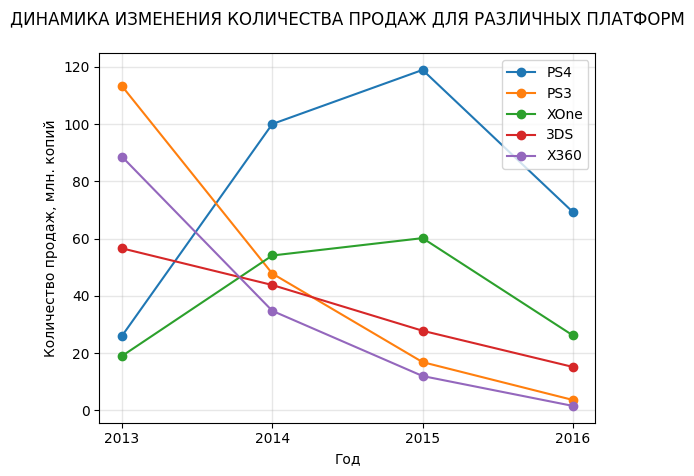

In [37]:
# проверим растут или падают продажи у топ-5 платформ
df = top5_full_info.pivot_table(index=['platform', 'year_of_release'], values='sum_sales', aggfunc='sum').reset_index(drop=False)

for platform in top5_platform_for_analysis.index:
    plt.plot(df[df['platform']==platform]['year_of_release'], df[df['platform']==platform]['sum_sales'], '-o')
    
    plt.legend(top5_platform_for_analysis.index)
    plt.title('Динамика изменения количества продаж для различных платформ\n'.upper())
    plt.xlabel('Год')
    plt.ylabel('Количество продаж, млн. копий')
    plt.xticks(np.arange(min(df[df['platform']==platform]['year_of_release']), max(df[df['platform']==platform]['year_of_release'])+1, 1.0))
    plt.grid(linewidth=1, alpha=0.3)

**Вывод:**

По результатам анализа данных можно сделать вывод, что для целей настоящей работы не имеет смысла рассматривать данные старше 5 лет.

По данным с 2012 по 2016 гг. платформы топ-5 по продажам: 
- PS4
- PS3 
- XOne
- 3DS
- X360

Используя данные 2016 г. можно заметить, что для всех платформ актуален нисходящий тренд в продажах. Вероятно, это связано с недостатком данных за 2016 г. 

Если исключить эти данные из анализа, то из графика можно сделать вывод, что следующие платформы становятся более популярными:
- PS4
- XOne

При этом платформы PS3, 3DS, X360 теряют свою популярность у игроков.

#### Анализ глобальных продаж игр на различных платформах

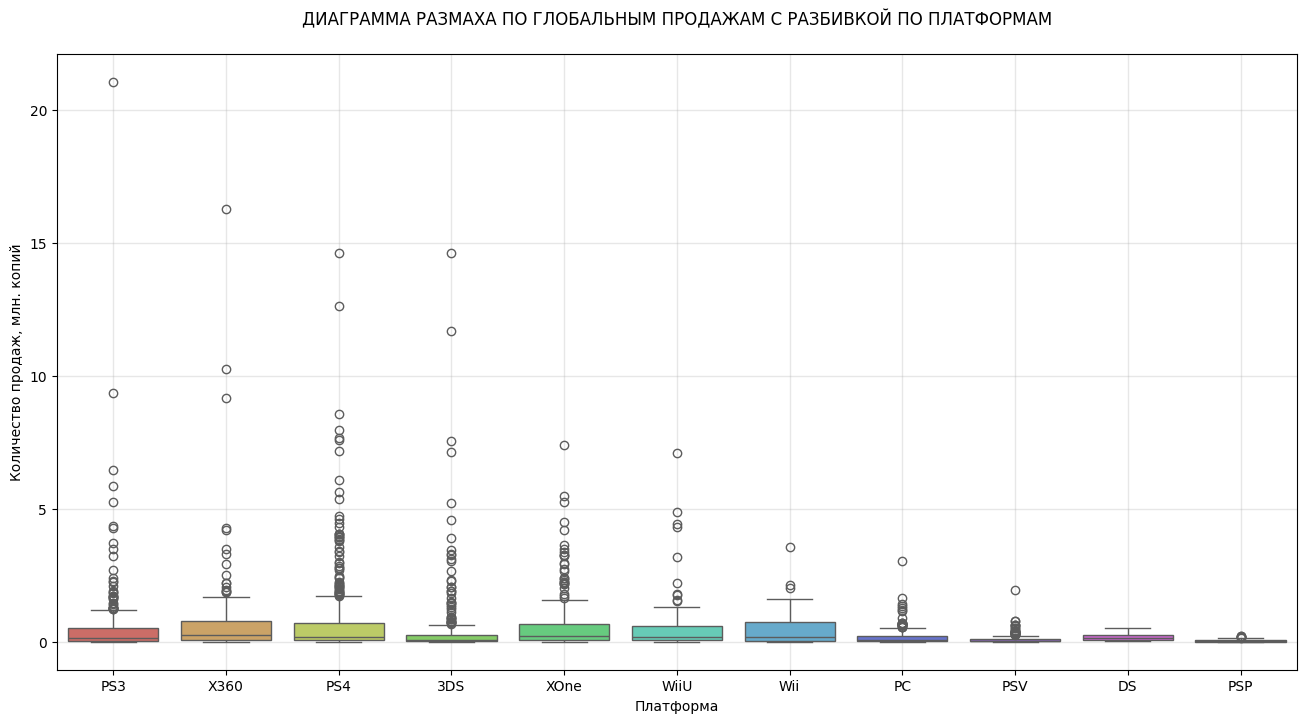

In [38]:
# построим диаграмму размаха по глобальным продажам с разбивкой по платформам
fig = plt.figure(figsize=(16,8))
sns.boxplot(data = games_for_analysis, x = 'platform', hue = 'platform', y='sum_sales', palette='hls')
plt.title('Диаграмма размаха по глобальным продажам с разбивкой по платформам\n'.upper())
plt.xlabel('Платформа')
plt.ylabel('Количество продаж, млн. копий')
plt.grid(linewidth=1, alpha=0.3);

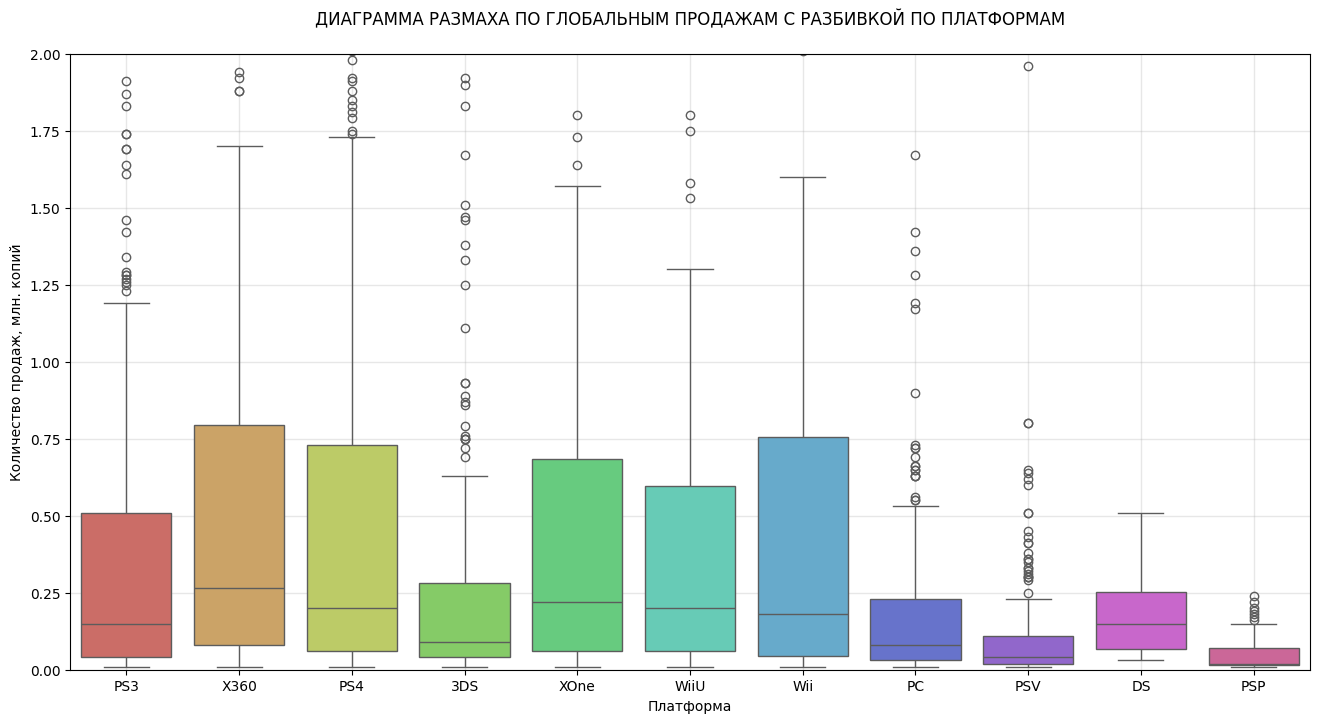

In [39]:
# на диаграмме выше сложно точно назвать медиану и квартили. 
# приблизим диаграмму
fig = plt.figure(figsize=(16,8))
sns.boxplot(data = games_for_analysis, x = 'platform', hue = 'platform', y='sum_sales', palette='hls')
plt.title('Диаграмма размаха по глобальным продажам с разбивкой по платформам\n'.upper())
plt.xlabel('Платформа')
plt.ylabel('Количество продаж, млн. копий')
plt.grid(linewidth=1, alpha=0.3)
plt.ylim(0, 2);

**Вывод:**

Для части платформ наблюдаются довольно большие выбросы (актуально для PS3, X360, PS4, 3DS). 

Для большинства платформ медианное значение количества продаж не превышает 0.25 млн.копий. 

#### Влияние на продажи отзывов пользователей и критиков

На примере наиболее популярной платформы PS4 проанализируем как влияют отзывы пользователей и критиков на продажи игр.

In [40]:
# создадим новый датафрейм с данными только по платформе PS4
ps4 = games_for_analysis[games_for_analysis['platform'] == 'PS4']

# проверим, что получили корректный датафрейм
ps4.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NA,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NA,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
143,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08
154,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39


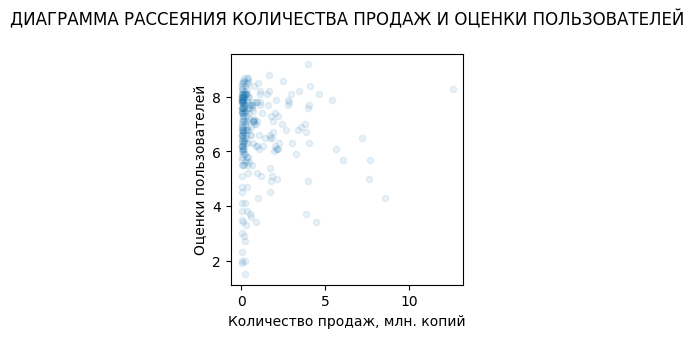

In [41]:
# построим диаграмму рассеяния между продажами и оценкой пользователей
ps4.plot(x='sum_sales', y='user_score', kind='scatter', alpha=0.1, \
         figsize=(3, 3), title='Диаграмма рассеяния количества продаж и оценки пользователей\n'.upper(), \
         xlabel='Количество продаж, млн. копий', ylabel='Оценки пользователей');

In [42]:
# посчитаем корреляцию между отзывами и продажами
ps4['sum_sales'].corr(ps4['user_score'])

np.float64(-0.031957110204556376)

Корреляция между отзывами и продажами для платформы PS3: 0.0023944027357566925
Корреляция между отзывами и продажами для платформы XOne: -0.06892505328279412
Корреляция между отзывами и продажами для платформы 3DS: 0.24150411773563016
Корреляция между отзывами и продажами для платформы X360: -0.011742185147181342


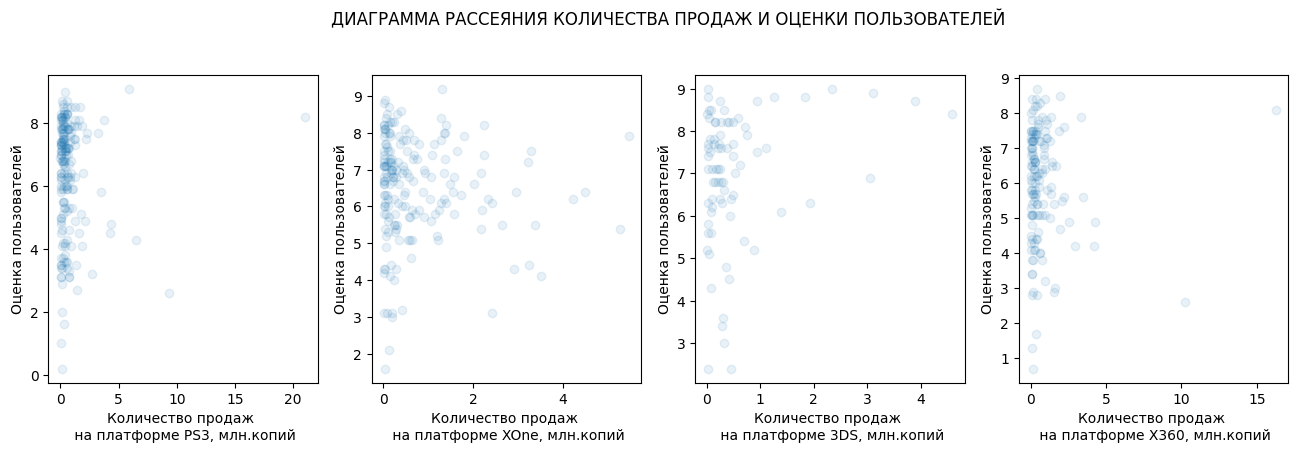

In [43]:
# соотнесем выводы с продажами игр на топ-5 популярных платформах
i = 1
plt.figure(figsize=(16, 4))

for platform in top5_platform_for_analysis.index:
    if platform != 'PS4':
        df = games_for_analysis[games_for_analysis['platform'] == platform]
        plt.subplot(1, 4, i)
        plt.scatter(x=df['sum_sales'], y=df['user_score'], alpha=0.1)
        plt.xlabel(f'Количество продаж \n на платформе {platform}, млн.копий')
        plt.ylabel('Оценка пользователей')

        i+=1     

        print(f"Корреляция между отзывами и продажами для платформы {platform}: {df['sum_sales'].corr(df['user_score'])}")

plt.title('Диаграмма рассеяния количества продаж и оценки пользователей\n\n'.upper(), position=(-1.3, 0));       

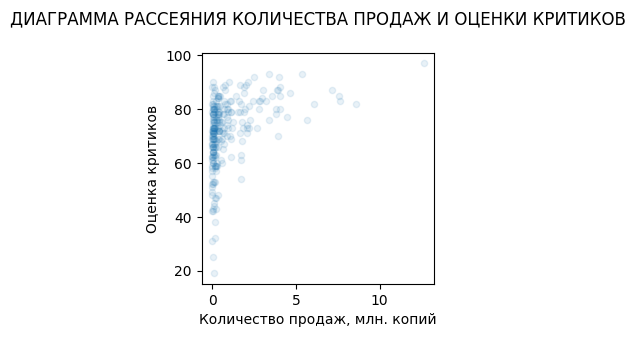

In [44]:
# построим диаграмму рассеяния между продажами и оценкой критиков 
ps4.plot(x='sum_sales', y='critic_score', kind='scatter', alpha=0.1, \
         figsize=(3, 3), title='Диаграмма рассеяния количества продаж и оценки критиков\n'.upper(), \
         xlabel='Количество продаж, млн. копий', ylabel='Оценка критиков');

In [45]:
# посчитаем корреляцию между отзывами и продажами
ps4['sum_sales'].corr(ps4['critic_score'])

np.float64(0.406567902061781)

Корреляция между отзывами и продажами для платформы PS3: 0.3342853393371919
Корреляция между отзывами и продажами для платформы XOne: 0.41699832800840175
Корреляция между отзывами и продажами для платформы 3DS: 0.35705661422881035
Корреляция между отзывами и продажами для платформы X360: 0.3503445460228664


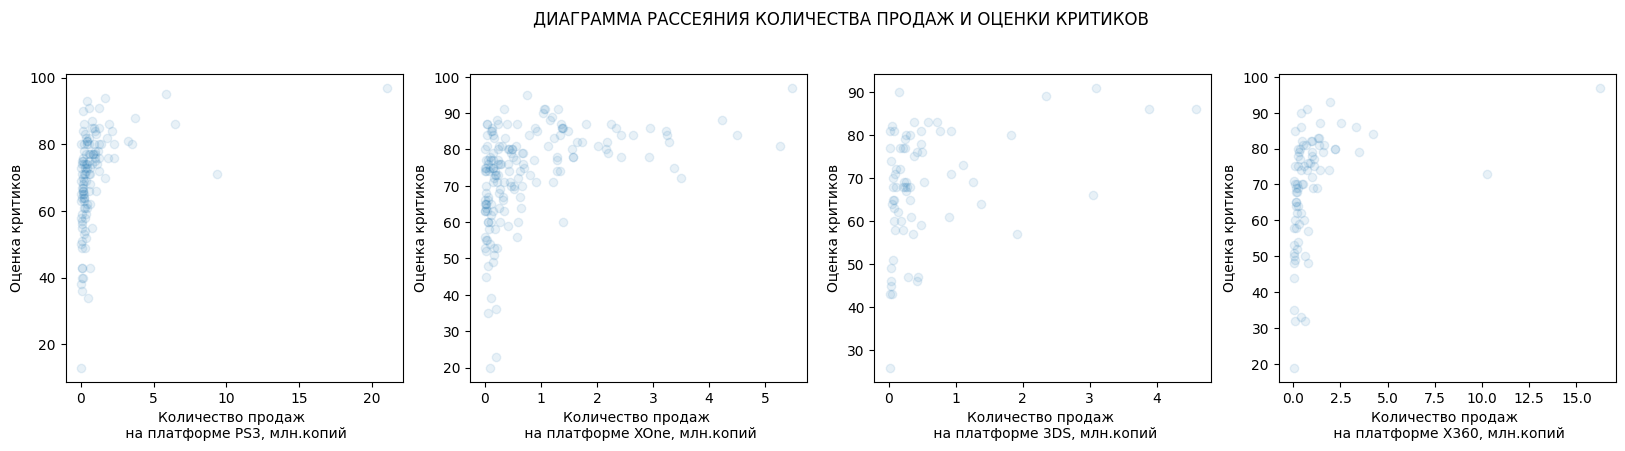

In [46]:
# соотнесем выводы с продажами игр на топ-5 популярных платформах
i = 1
plt.figure(figsize=(20, 4))

for platform in top5_platform_for_analysis.index:
    if platform != 'PS4':
        df = games_for_analysis[games_for_analysis['platform'] == platform]
        plt.subplot(1, 4, i)
        plt.scatter(x=df['sum_sales'], y=df['critic_score'], alpha=0.1)
        plt.xlabel(f'Количество продаж \n на платформе {platform}, млн.копий')
        plt.ylabel('Оценка критиков')

        i+=1     

        print(f"Корреляция между отзывами и продажами для платформы {platform}: {df['sum_sales'].corr(df['critic_score'])}")

plt.title('Диаграмма рассеяния количества продаж и оценки критиков\n\n'.upper(), position=(-1.3, 0));       

**Вывод:**

На примере данных для платформы PS4 выявлена корреляция между количеством продаж и оценкой критиков (чем выше оценка критиков, тем выше продажи). 

Отсутствует корреляция между продажами и оценкой пользователей. 

Текущие выводы подтвердились и для других популярных платформ (PS3, XOne, 3DS, X360).

#### Распределение игр по жанрам

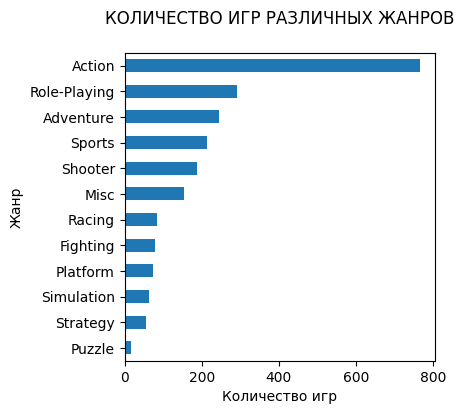

In [47]:
# получим график с количеством игр различных жанров
games_for_analysis.value_counts('genre').sort_values()\
    .plot(kind='barh', title='Количество игр различных жанров\n'.upper(), figsize=(4, 4), legend='')
plt.xlabel('Количество игр')
plt.ylabel('Жанр');

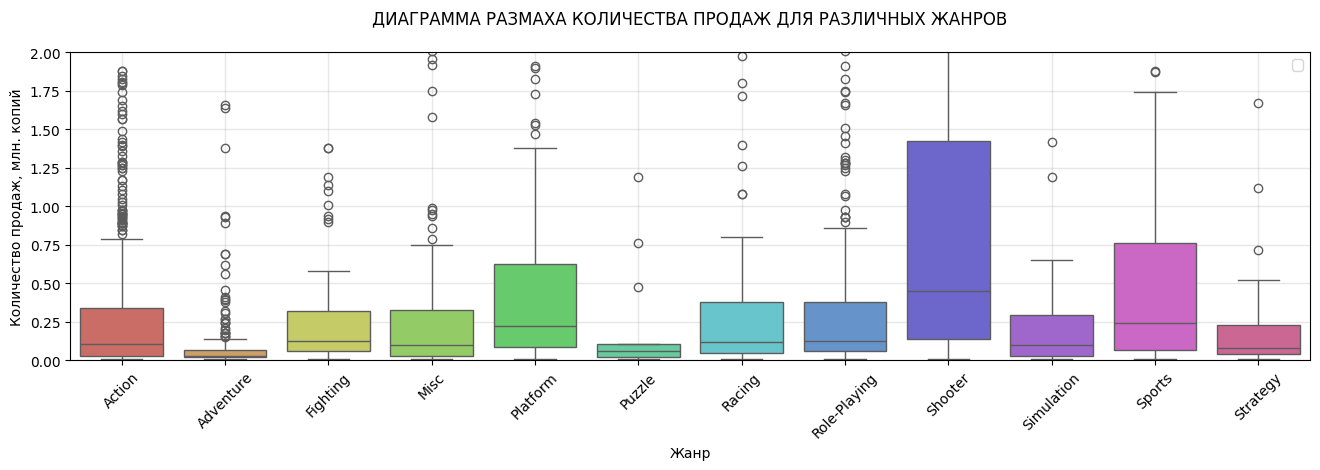

In [48]:
# построим диаграмму размаха количества продаж для различных жанров
plt.figure(figsize=(16, 4))
sns.boxplot(data = games_for_analysis.sort_values(by='genre'), x = 'genre', hue = 'genre', y='sum_sales', palette='hls')
plt.title('Диаграмма размаха количества продаж для различных жанров\n'.upper())
plt.xlabel('Жанр')
plt.xticks(rotation=45)
plt.ylabel('Количество продаж, млн. копий')
plt.grid(linewidth=1, alpha=0.3)
plt.ylim(0, 2)
plt.legend('');

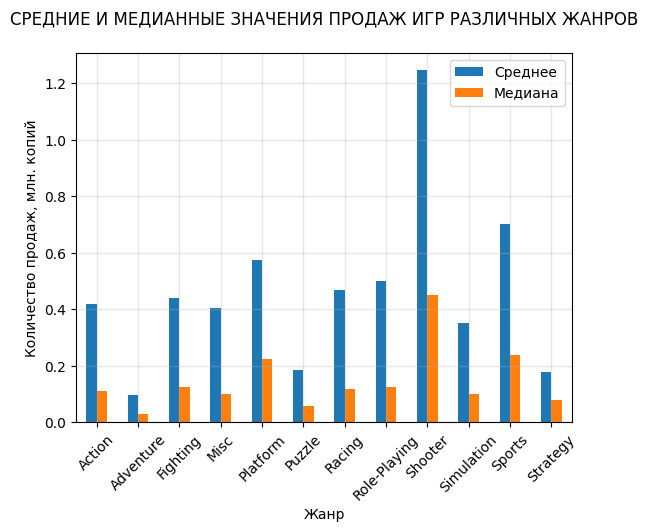

In [49]:
# построим график, отражающий медианные и средние значения количества продаж для различных жанров
games_for_analysis.pivot_table(index='genre', values='sum_sales', aggfunc=['mean', 'median']).sort_values(by='genre').plot(kind='bar')

plt.title('Средние и медианные значения продаж игр различных жанров\n'.upper())
plt.legend(['Среднее', 'Медиана'])
plt.xlabel('Жанр')
plt.xticks(rotation=45)
plt.ylabel('Количество продаж, млн. копий')
plt.grid(linewidth=1, alpha=0.3);

**Вывод:**

Лидером по количеству выпущенных игр являются жанры: 
- Action
- Role-playing

Меньше всего игр выпускается в жанрах:
- Strategy
- Puzzle

Больше всего проданных копий игр в жанрах:
- Shooter
- Sports
- Platform

Реже всего продаются жанры:
- Adventure
- Puzzle

Цель исследовательского анализа данных заключалась в анализе полученных данных, поиск актуального набора данных, формировании промежуточных выводов о ситуации в игровой индустрии. 

В результате исследовательского анализа был сформирован актуальный набор данных, и на его основе было выявлено:
- больше всего игр было выпущено в 2007 году;
- медианный срок жизни платформ - 7 лет;
- наиболее популярными на период 2016 года являются платформы PS4, XOne;
- отзывы пользователей не влияют на количество продаж, в отличие от отзывов критиков;
- наиболее прибыльные жанры - Shooter, Sports, Platform;
- менее прибыльные жанры - Adventure, Puzzle.

В качестве дальнейших шагов требуется:
- составить портрет пользователя для регионов Северной Америки, Европы, Японии;
- проверить гипотезы.

### Составление портрета пользователя каждого региона

In [50]:
# напишем функцию, которая формирует 3 графика по заданному региону
def graphics_for_regions(df, region):
    
    #platforms_info = df.pivot_table(index='platform', values=region, aggfunc='sum').sort_values(by='platform', ascending=False)
    
    # исправленная строка
    platforms_info = df.pivot_table(index='platform', values=region, aggfunc='sum').sort_values(by=region, ascending=False)
    
    platform_result = platforms_info.head(5).reset_index(drop=False)
    platform_result.loc[len(platform_result)] = {'platform':'Other', region: platforms_info.tail(-5)[region].sum()}

    #genre_info = df.pivot_table(index='genre', values=region, aggfunc='sum').sort_values(by='genre', ascending=False)
    
    # исправленная строка
    genre_info = df.pivot_table(index='genre', values=region, aggfunc='sum').sort_values(by=region, ascending=False)
    
    genre_result = genre_info.head(5).reset_index(drop=False)
    genre_result.loc[len(genre_result)] = {'genre':'Other', region: genre_info.tail(-5)[region].sum()}

    rating_info = df.pivot_table(index='rating', values=region, aggfunc='sum').sort_values(by='rating', ascending=False)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    platform_result[region].plot(kind='pie', subplots=True, autopct='%1.1f%%', labels=platform_result['platform'])
    plt.xlabel('Платформы')
    plt.ylabel('')

    plt.subplot(1, 3, 2)
    genre_result[region].plot(kind='pie', subplots=True, autopct='%1.1f%%', labels=genre_result['genre'])
    plt.xlabel('Жанры')
    plt.ylabel('')
    
    plt.subplot(1, 3, 3)
    rating_info[region].plot(kind='pie', subplots=True, legend='', autopct='%1.1f%%', ylabel='')
    plt.xlabel('Рейтинги')
    
    if region == 'eu_sales':
        plt.title('Европа'.upper(), position=(-0.7, 0));
    elif region == 'na_sales':
        plt.title('Северная Америка'.upper(), position=(-0.9, 0));
    else:
        plt.title('Япония'.upper(), position=(-0.7, 0));

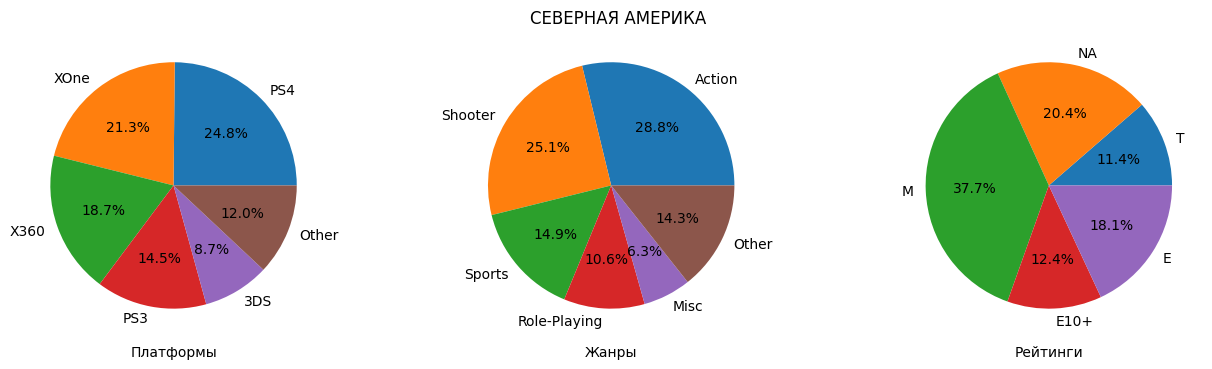

In [51]:
# сформируем графики для США
graphics_for_regions(games_for_analysis, 'na_sales')

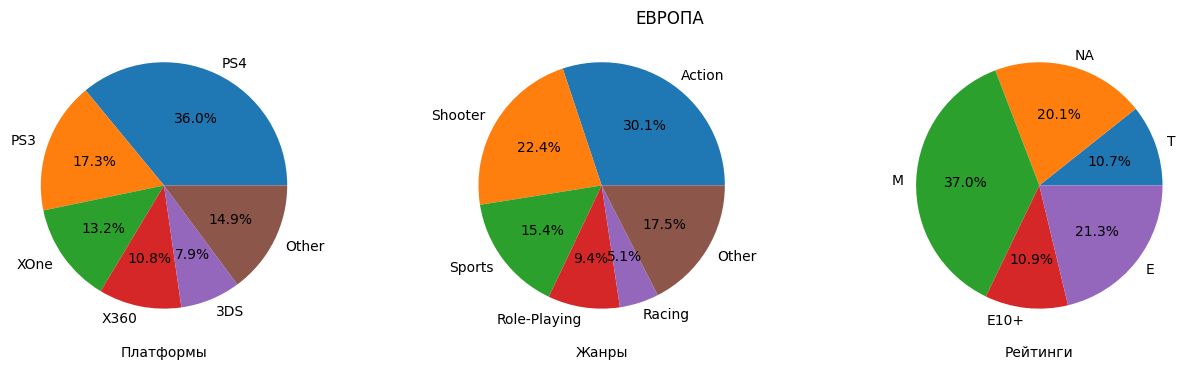

In [52]:
# сформируем графики для Европы
graphics_for_regions(games_for_analysis, 'eu_sales')

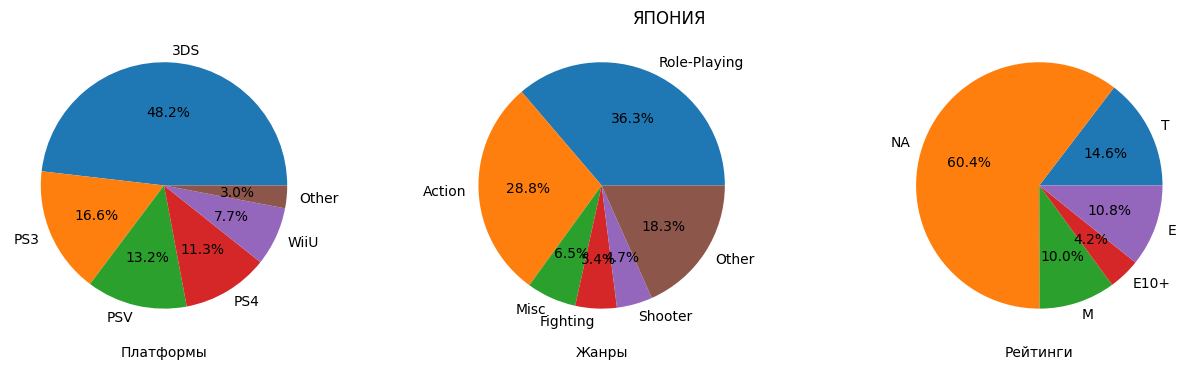

In [53]:
# сформируем графики для Японии
graphics_for_regions(games_for_analysis, 'jp_sales')

**Вывод:**

Графики для *Европы и Северной Америки* с долями продаж игр очень похожи. 

Для этих регионов можно выделить две наиболее популярные (конкурирующие) платформы - XOne и X360 (в Северной Америке почти в равных долях, в Европе лидирует PS4). 

Топ-5 популярных платформ в этих регионах закрывает платформа 3DS. 

Самый популярный жанр - Action, за ним немного отстают Shooter, Aports. 

Менее популярный жанр из топ-5 - Misc в США и Racing в Европе.

Наиболее часто в Европе и Северной Америке покупают игры с рейтингом M, рейтинги Е10+ и Т наименее популярны в равной степени. 

Противоположная ситуация в регионе *Японии*. 

Наиболее популярной является платформа 3DS (почти половина всего рынка).

Наименее популярные платформы из топ-5 - WiiU и PS4.

В Японии жанр-лидер - Role-Playing, за ним следует Action. Наименее популярный игровой жанр в Японии из топ-5 - Shooter.

Наиболее часто в Японии покупают игры с рейтингом Т, далее практически равные по популярности Е и М, а Е10+ наименее популярны. 

Можно заметить, что в Японии гораздо больше игр, для которых не рассчитывался рейтинг ESRB, т.к. эта система используется в первую очередь в США. 

*Примечание:*
- *Е - для всех*
- *Е10+ - для всех от 10 лет и старше*
- *Т - подростки*
- *М - для взрослых*

### Проверка гипотез

#### Гипотеза 1

H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1 - Средние пользовательские рейтинги платформ Xbox One и PC разные

In [54]:
xbox = games_for_analysis[games_for_analysis['platform']=='XOne']['user_score'].dropna()
pc = games_for_analysis[games_for_analysis['platform']=='PC']['user_score'].dropna()

# зададим уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю
results = st.ttest_ind(xbox, pc)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.14012658403611647
Нет оснований отвергнуть нулевую гипотезу


In [55]:
# посмотрим средние пользовательские рейтинги 
print(f'Среднее значение пользовательских рейтингов платформы Xbox - {xbox.mean()}')
print(f'Среднее значение пользовательских рейтингов платформы PC - {pc.mean()}')

Среднее значение пользовательских рейтингов платформы Xbox - 6.521428571428572
Среднее значение пользовательских рейтингов платформы PC - 6.2696774193548395


#### Гипотеза 2

H0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

H1 - Средние пользовательские рейтинги жанра Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различаются.

In [56]:
action = games_for_analysis[games_for_analysis['genre']=='Action']['user_score'].dropna()
sports = games_for_analysis[games_for_analysis['genre']=='Sports']['user_score'].dropna()

# зададим уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(action, sports)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


In [57]:
# посмотрим средние пользовательские рейтинги 
print(f'Среднее значение пользовательских рейтингов для жанра Action - {action.mean()}')
print(f'Среднее значение пользовательских рейтингов для жанра Sports - {sports.mean()}')

Среднее значение пользовательских рейтингов для жанра Action - 6.837532133676092
Среднее значение пользовательских рейтингов для жанра Sports - 5.238124999999999


**Вывод:**

В обоих случаях на вход подавались две генеральные совокупности. Когда сравнивают средние двух генеральных совокупностей, нулевую гипотезу можно сформулировать так: «средние значения совокупностей равны». 

Альтернативная гипотеза может быть как двусторонней, так и односторонней. Проверялись двусторонние гипотезы в обоих случаях. 

Для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем статистический тест с использованием t-распределения (t-тест).

По результатам проверки гипотез (при установленном уровне значимости = 5%) есть основания говорить, что:
- средние пользовательские рейтинги платформ Xbox One и PC равны;
- средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») отличаются.

### Общий вывод

1. Была выполнена предобработка данных:
- корректировка названий столбцов;
- удалены строки, в которых были пропущены значения в столбцах `name` и `genre`;
- удалили строки с пропусками в столбце `year_of_release`;
- в столбце `user_score` заменили значение *tbd* ("to be determined", "будет определено") на пропуски;
- в столбцах `year_of_release`, `user_score` был скорректирован тип данных;
- вместо пропущенных значений в столбце `rating` вставили заглушку (NA);
- добавлен новый столбец `sum_sales` с суммарным количеством продаж во всех регионах. 

Пропущенные значения в основном могут быть обусловлены процессами сбора данных (рейтинг, оценка пользователей или критиков может не выставляться для 100% игр в выборке (в т.ч. рейтинг ESRB используется преимущественно в США)) или техническими ошибками при выгрузке данных. 

2. Проведен исследовательский анализ данных:

- больше всего игр было выпущено в 2007 году. До 1992 года игры выпускались довольно редко, поэтому для дальнейшего анализа оставили только строки с играми, выпущенными после 1992 года;
- было выявлено, что медианный срок жизни платформ - 7 лет. Поэтому для дальнейшего анализа оставили только данные не старше 5 лет;
- к 2017 году станут популярными следующие платформы:
    - PS4;
    - XOne;
- платформы PS3, 3DS, X360 теряют свою популярность у игроков;
- для большинства платформ медианное значение количества продаж не превышает 0.25 млн.копий;
- на примере 5 наиболее популярных платформ выявлена корреляция между количеством продаж и оценкой критиков (чем выше оценка критиков, тем выше продажи);
- на примере 5 наиболее популярных платформ выявлено отсутствие корреляции между продажами и оценкой пользователей;
- наиболее прибыльные жанры - Shooter, Sports, Platform;
- менее прибыльные жанры - Adventure, Puzzle.

3. Составлен портрет пользователя каждого региона. 

Портрет пользователей в регионе Европа и Северная Америка практически одинаковый: 
- пользователь платформ XOne или PS4;
- предпочитает игры жанра Action и Shooter;
- взрослый (рейтинг M).


Портрет пользователя в регионе Япония:
- пользователь платформы 3DS;
- предпочитает игры жанра Role-Playing или Action;
- подросток (рейтинг T).

4. Проверены гипотезы о платформах и жанрах игр:
- средние пользовательские рейтинги платформ Xbox One и PC равны;
- средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») отличаются.

**Рекомендации:**

1. Предпочтения в платформах, жанрах и возрастных ограничениях отличаются для различных регионов.
2. Для продвижения игры стоит обращать особое внимание на ее оценку критиками, т.к. она влияет на количество продаж. 
3. Для разработки игры, которую планируется выпускать в регионе Европы и Северной Америки, стоит рассматривать только платформы набирающие популярность - PS4 и (или) XOne, для Японии - 3DS. 
4. При выборе жанра игры в регионе Европы и Северной Америки стоит присмотреться к жанру Action и Shooter, для Японии - Role-playing и Action.
5. В регионе Европы и Северной Америки стоит отдать предпочтения рейтингу М (для взрослых), в Японии - рейтингу Т (для подростков). 
6. Рекомендуемый регион - Северная Америка или Европа. 